In [1]:
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [2]:
tickers = ['PATH', 'PLTR', 'AI', 'BBAI']  # List of ticker symbols
start_date = '2021-04-21'
end_date = datetime.today().strftime('%Y-%m-%d')

# Download data for all tickers and create a DataFrame with closing prices
data = yf.download(tickers, start=start_date, end=end_date, interval='1d')['Close']

# Drop the ticker labels, leaving only the closing prices with the date index
data.columns = [f'Stock {i+1}' for i in range(len(data.columns))]

# Display the combined DataFrame
print(data.head())

[*********************100%***********************]  4 of 4 completed

                             Stock 1  Stock 2    Stock 3    Stock 4
Date                                                               
2021-04-21 00:00:00+00:00  66.510002     9.77  69.000000  22.629999
2021-04-22 00:00:00+00:00  67.160004     9.77  75.500000  22.860001
2021-04-23 00:00:00+00:00  69.330002     9.77  74.839996  23.410000
2021-04-26 00:00:00+00:00  72.489998     9.72  80.809998  24.110001
2021-04-27 00:00:00+00:00  70.910004     9.73  75.370003  23.879999


In [3]:
data.reset_index(inplace=True)
data['Date'] = pd.to_datetime(data['Date'])
dates = data['Date']
data = data[['Stock 1', 'Stock 2', 'Stock 3', 'Stock 4']]
log_returns = np.log(data / data.shift(1))
portfolio_log_return = (
    0.25 * log_returns['Stock 1'] +
    0.25 * log_returns['Stock 2'] +
    0.25 * log_returns['Stock 3'] +
    0.25 * log_returns['Stock 4']
)

In [4]:
portfolio = pd.DataFrame({
    'Portfolio Log Return': portfolio_log_return,
    'Date': dates
})

In [5]:
scaler = MinMaxScaler()

portfolio['Normalized Portfolio Log Return'] = scaler.fit_transform(portfolio[['Portfolio Log Return']])

Volatility around Start of AI hype (2022-12-22 to 2023-01-11): 0.063806


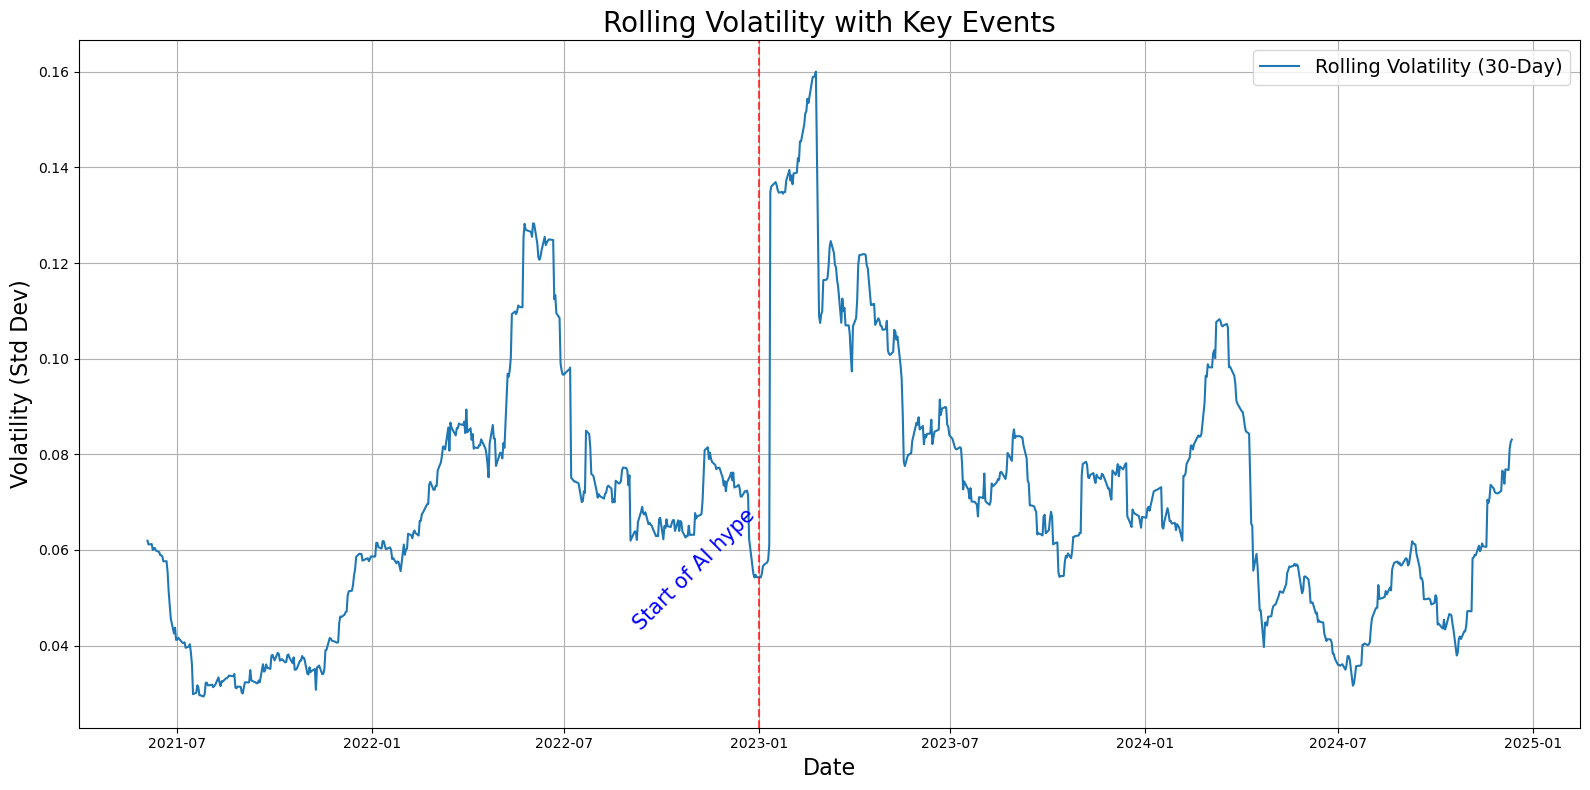

In [12]:
events = [
    ("2023-01-01", "Start of AI hype")
]

portfolio['Date'] = pd.to_datetime(portfolio['Date'])

portfolio['Rolling Volatility'] = portfolio['Normalized Portfolio Log Return'].rolling(window=30).std()
plt.figure(figsize=(16, 8))
plt.plot(portfolio['Date'], portfolio['Rolling Volatility'], label='Rolling Volatility (30-Day)')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Volatility (Std Dev)', fontsize=16)
plt.title('Rolling Volatility with Key Events', fontsize=20)
plt.grid(True)

vol_min = portfolio['Rolling Volatility'].min()
vol_max = portfolio['Rolling Volatility'].max()
label_y = vol_min + 0.1 * (vol_max - vol_min)

for date, label in events:
    event_date = pd.to_datetime(date).tz_localize('UTC') 
    window_start = event_date - pd.Timedelta(days=10)
    window_end = event_date + pd.Timedelta(days=10)
    plt.axvline(x=event_date, color='red', linestyle='--', alpha=0.7)
    plt.text(event_date, label_y, label,
             rotation=45, fontsize=15, color='blue',
             ha='right', va='bottom') 
    window_volatility = portfolio[
        (portfolio['Date'] >= window_start) & (portfolio['Date'] <= window_end)
    ]['Normalized Portfolio Log Return'].std()
    print(f"Volatility around {label} ({window_start.date()} to {window_end.date()}): {window_volatility:.6f}")

plt.ylim(vol_min - 0.05 * (vol_max - vol_min), vol_max + 0.05 * (vol_max - vol_min))
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()
